In [1]:
%pylab inline
import time
import os 
image_dir = os.getcwd() + '/images/'
model_dir = os.getcwd() + '/models/'

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import torchvision
from torchvision import transforms

from PIL import Image
import copy

Populating the interactive namespace from numpy and matplotlib


## VGG

In [2]:
#vgg definition that conveniently let's you grab the outputs from any layer
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)
            
    def forward(self, x, out_keys):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        return [out[key] for key in out_keys]

In [3]:
#get network
vgg = VGG()
vgg.load_state_dict(torch.load(model_dir + 'vgg_conv.pth'))
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

## Sub Convnets

In [4]:
#
class Layer(nn.Module):
    def __init__(self, linear):
        super(Layer, self).__init__()
        self.linear = linear
    
    def forward(self, inputs):
        outputs = self.linear(inputs)
        return F.relu(outputs)
    
#
class Net(nn.Module):
    def __init__(self, layers):
        super(Net, self).__init__()
        self.layers = nn.Sequential(*layers)
    
    def forward(self, inputs):
        return self.layers(inputs)

In [5]:
#
subnets = []
subnets += [Net([Layer(vgg.conv1_1)])]
subnets += [Net([Layer(vgg.conv1_2),
                 vgg.pool1,
                 Layer(vgg.conv2_1)])]
subnets += [Net([Layer(vgg.conv2_2),
                 vgg.pool2,
                 Layer(vgg.conv3_1)])]
subnets += [Net([Layer(vgg.conv3_2),
                 Layer(vgg.conv3_3),
                 Layer(vgg.conv3_4),
                 vgg.pool3,
                 Layer(vgg.conv4_1)])]
subnets += [Net([Layer(vgg.conv4_2),
                 Layer(vgg.conv4_3),
                 Layer(vgg.conv4_4),
                 vgg.pool4,
                 Layer(vgg.conv5_1)])]

## Pre and Post Processing

In [6]:
# pre and post processing for images
img_size = 256  # 64, 128, 256, 512 
prep = transforms.Compose([transforms.Scale(img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor).clamp_(0, 1)
    img = postpb(t)
    return img

## Load Images

In [7]:
#load images, ordered as [style_image, content_image]
img_dirs = [image_dir, image_dir]
img_names = ['style.png', 'content.png']
imgs = [Image.open(img_dirs[i] + name) for i,name in enumerate(img_names)]
imgs_torch = [prep(img) for img in imgs]
if torch.cuda.is_available():
    imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
else:
    imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
style_image, content_image = imgs_torch

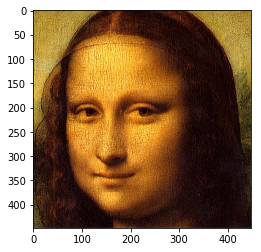

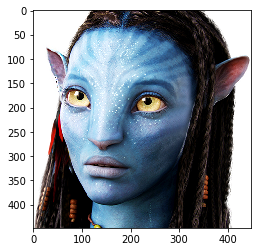

In [8]:
#display images
for img in imgs:
    imshow(img);show()

## Deconvolution

In [9]:
#
def deconvolve(l, subnets, targets, value=None):
    t = targets[l]
    
    cnn = copy.deepcopy(subnets[l])
    cnn.cuda()
    
    optimum = value if value is not None else Variable(torch.randn(t.size()).type_as(t.data), requires_grad=True)
    loss_fn = nn.MSELoss()
    
    optimizer = optim.LBFGS([optimum])
    
    max_iter = 2500
    show_iter = 50
    n_iter=[0]

    while n_iter[0] <= max_iter:

        def closure():
            optimizer.zero_grad()
            loss = loss_fn(cnn(optimum), targets[l+1])
            loss.backward()
            n_iter[0]+=1
            #print loss
            if n_iter[0]%show_iter == (show_iter-1):
                print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.data[0]))
            return loss

        optimizer.step(closure)
    return optimum

In [10]:
#
content_targets = [content_image] + vgg(content_image, ["r11", "r21","r31","r41","r51"])
style_targets = [style_image] + vgg(style_image, ["r11", "r21","r31","r41","r51"])

Iteration: 50, loss: 3374.402344
Iteration: 100, loss: 3372.860596
Iteration: 150, loss: 3371.270020
Iteration: 200, loss: 3369.635254
Iteration: 250, loss: 3367.957764
Iteration: 300, loss: 3366.241211
Iteration: 350, loss: 3364.487793
Iteration: 400, loss: 3362.700928
Iteration: 450, loss: 3360.883301
Iteration: 500, loss: 3359.035889
Iteration: 550, loss: 3357.159424
Iteration: 600, loss: 3355.257324
Iteration: 650, loss: 3353.331055
Iteration: 700, loss: 3351.381348
Iteration: 750, loss: 3349.411133
Iteration: 800, loss: 3347.422363
Iteration: 850, loss: 3345.415039
Iteration: 900, loss: 3343.390625
Iteration: 950, loss: 3341.351562
Iteration: 1000, loss: 3339.298828
Iteration: 1050, loss: 3337.233154
Iteration: 1100, loss: 3335.156006
Iteration: 1150, loss: 3333.067871
Iteration: 1200, loss: 3330.969727
Iteration: 1250, loss: 3328.863281
Iteration: 1300, loss: 3326.748291
Iteration: 1350, loss: 3324.625732
Iteration: 1400, loss: 3322.495850
Iteration: 1450, loss: 3320.359375
Itera

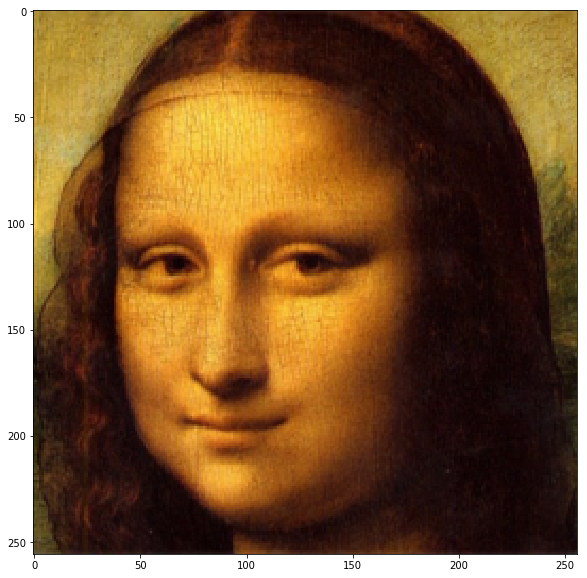

In [11]:
#
opt = deconvolve(0, subnets, targets)

#display result
out_img = postp(opt.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)

## Utils for later phases

In [12]:
#
def get_weight_map(features, alpha, kappa = 300, tau = 0.05):
    # feature maps of shape [batch_size n_channels, height, width]
    # normalize features maps across the channel dimension
    x = F.normalize(features, p=1, dim=1)
    # we suppose the batch size is 1 as we use 1 image only (this may change later?)
    # thus, we remove the batch dimension
    x = torch.squeeze(x, 0)
    return alpha * torch.sigmoid(kappa * torch.norm(x, p=2) + tau)


In [13]:
# upsampling
# mode = 'nearest', 'linear', 'bilinear', 'trilinear'
def upsample(inputs, size, mode="nearest"):
    return F.upsample(inputs, size=size, mode=mode)